# **Benchmark Image Similarity**
Author : Bayu Aditya

**Source :**

1. Paper : https://arxiv.org/abs/1710.02726
2. Hashing Image https://github.com/JohannesBuchner/imagehash
3. SIFT : https://gist.github.com/soruly/bd02a218690fe4e19295de3f5bede242#file-compre-py-L25
4. SURF : https://github.com/makelove/OpenCV-Python-Tutorial/blob/master/ch33-%E4%BB%8B%E7%BB%8DSURF/surf.py

In [1]:
import os
import cv2
import numpy as np
import PIL
import imagehash
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

from Image_Augmentation import image_augmentation
from similarity_backup import compareSIFT, compareSURF, compareORB

print('OpenCV               : {}'.format(cv2.__version__))
print('Python Image Library : {}'.format(PIL.__version__))
print('Imagehash            : {}'.format(imagehash.__version__))
print('Matplotlib           : {}'.format(mpl.__version__))
print('Seaborn              : {}'.format(sns.__version__))

OpenCV               : 3.4.2
Python Image Library : 5.3.0
Imagehash            : 4.0
Matplotlib           : 3.0.1
Seaborn              : 0.9.0


# 1. Input List Image Key

In [2]:
DIR_DATASET = 'image_plate_benchmark/image_bbox/'
NUM_SAMPLE = 10

In [3]:
data = os.listdir(DIR_DATASET)

image_key_list = []
for i in range(NUM_SAMPLE):
    indeks = np.random.randint(low = 0, high = len(data))
    image = cv2.imread(DIR_DATASET + data[indeks])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    class_aug = image_augmentation(image)
    dict_img_aug = class_aug.get_result()
    
    if (i % 3) == 0:
        image = dict_img_aug['get_shear']['left']
    elif (i % 3) == 1:
        image = dict_img_aug['get_crop']['high']
    elif (i % 3) == 2:
        image = dict_img_aug['get_rotate']['left']
        
    image_key_list.append(image)

class_aug.param

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


{'get_blur': ['very_low', 'low', 'med', 'high'],
 'get_crop': ['very_low', 'low', 'med', 'high'],
 'get_intensity': ['glow', 'dark'],
 'get_noise': ['gaussian', 's&p', 'speckle'],
 'get_rotate': ['left', 'right'],
 'get_scale': ['small', 'big'],
 'get_shear': ['left', 'right'],
 'get_translate': ['up', 'down', 'right', 'left']}

# 2. Image Similarity

## 2.1. Hashing Image Similarity

In [4]:
def hashing_value(img):
    if (type(img) == np.ndarray):
        image = PIL.Image.fromarray(img)
    hashing = imagehash.average_hash(image)
    return hashing

def hashing_distance(img1, img2):
    hash1 = hashing_value(img1)
    hash2 = hashing_value(img2)
    distance = hash1 - hash2
    return distance

def resize(img, shape = (120, 20)):
    #print(img.shape)
    #if (len(img.shape) == 3):
    #    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    shape_new = (shape[1], shape[0])
    img = cv2.resize(img, shape_new)
    #print(img.shape)
    return img

In [5]:
def summary_hashing_image(_img_key, _data):
    hash_dist_list = []
    image_list = []
    for i in range(len(_data)):
        name = _data[i]
        img = cv2.imread(DIR_DATASET + name)
        img = resize(img, shape = _img_key.shape)
        hash_dist = hashing_distance(_img_key, img)
        hash_dist_list.append((i, hash_dist))
        image_list.append(img)
        
    # Mengurutkan nilai dari yang terkecil ke terbesar
    hash_dist_list.sort(key=(lambda x : x[1]))
    
    # Normalisasi nilai
    hash_dist_list = np.array(hash_dist_list)
    hash_dist_list[:,1] = 100 - (( hash_dist_list[:,1] - hash_dist_list[:,1].min() )* 100/( hash_dist_list[:,1].max() - hash_dist_list[:,1].min() ))
    #hash_dist_list[:,1] = 100 - (( hash_dist_list[:,1] - 0.0 )/( hash_dist_list[:,1].max() - 0.0 ) * 100)
    
    rank = 0
    f = plt.figure(figsize = (30,2))
    ax = f.add_subplot(1, 5, 1)
    ax.imshow(_img_key)
    plt.title('Image Key')
    
    for i, dist in hash_dist_list[:3]:
        rank += 1
        title = 'Rank : {:3d}  Confident Level : {:7.4f} %'.format(rank, dist)
        ax = f.add_subplot(1, 5, rank+1)
        image = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        plt.title(title)
        
    ax = f.add_subplot(1, 5, 5)
    #ax.hist(hash_dist_list[:,1], bins = 10)
    sns.kdeplot(hash_dist_list[:,1])
    plt.xlim(0,100)
    plt.show()
        #display_image(image_list[i], title = title)

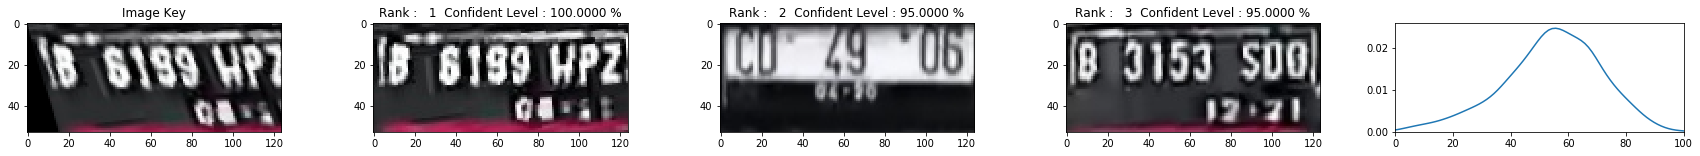

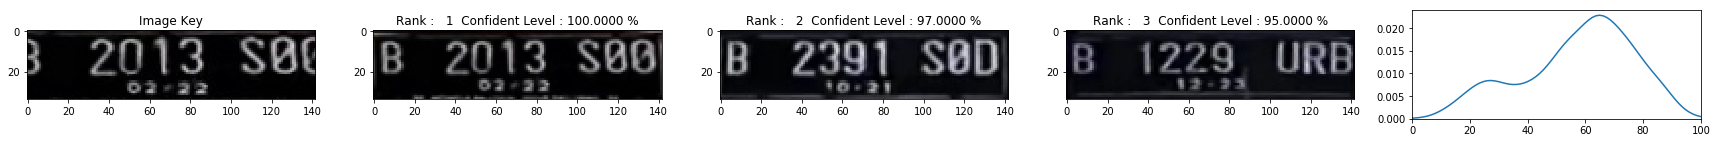

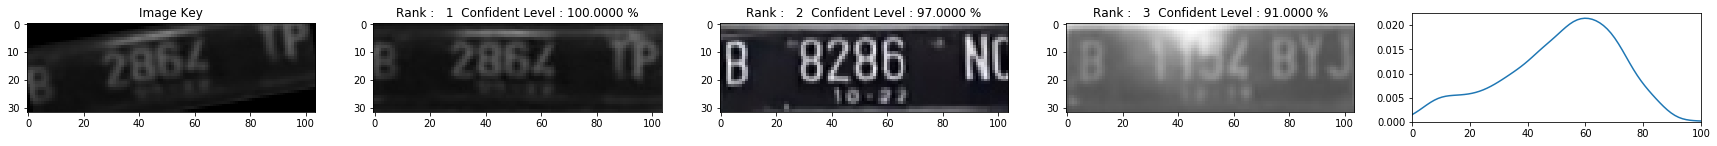

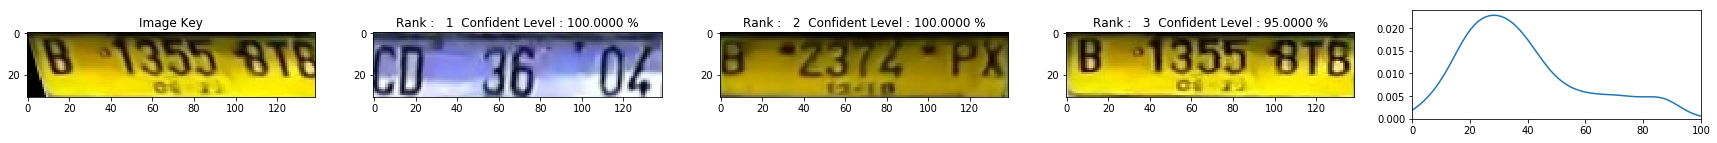

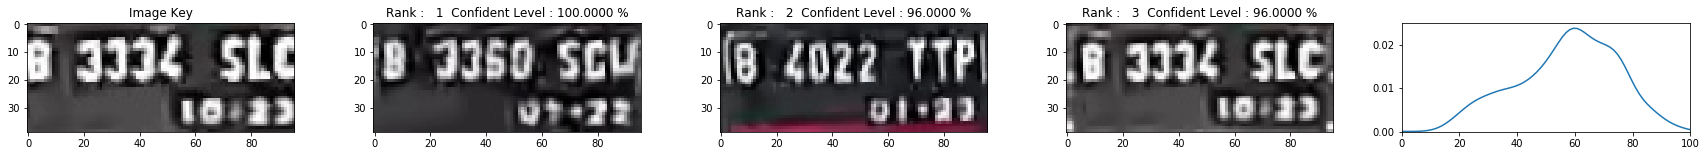

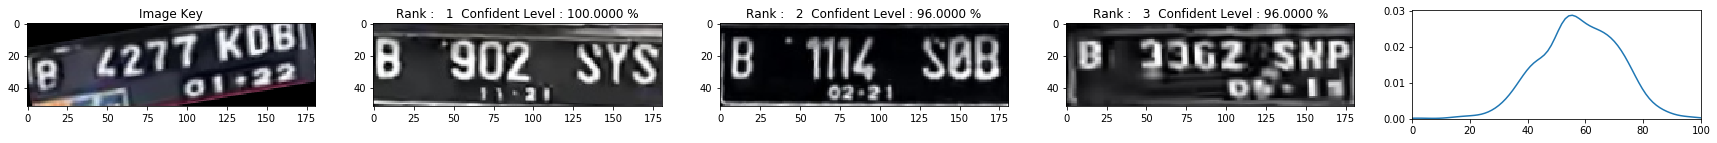

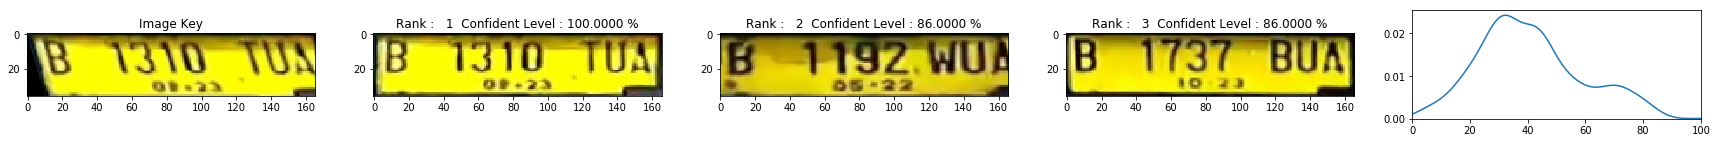

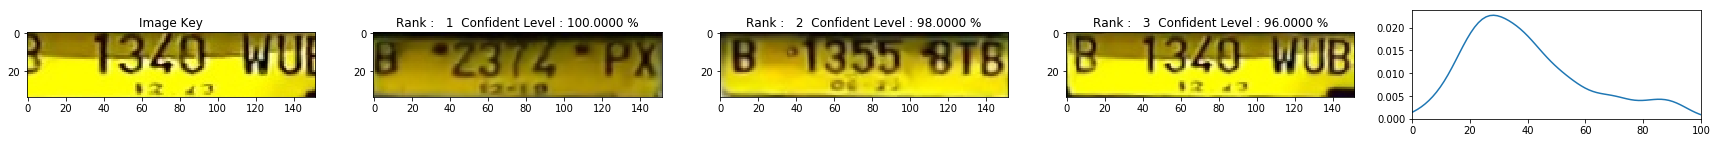

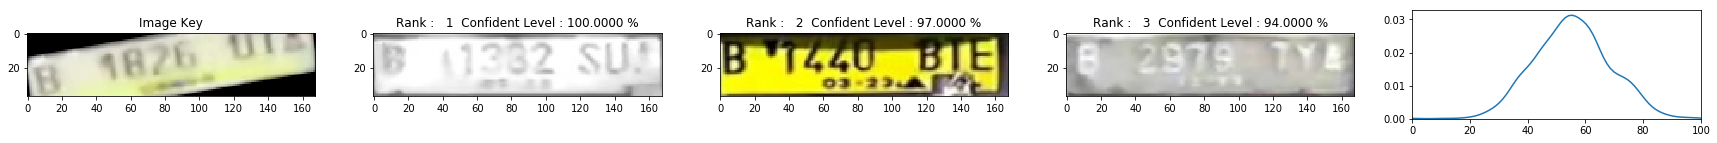

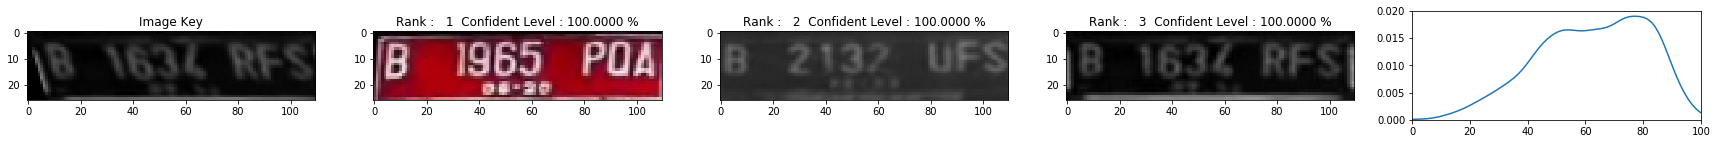

Duration : 0:00:11.881147
Duration similarity per image key : 0:00:01.188115
Duration similarity image per image : 0:00:00.001039


In [6]:
start_time = datetime.now()

for image in image_key_list:
    summary_hashing_image(image, data)

end_time = datetime.now()
print('Duration : {}'.format(end_time - start_time))
print('Duration similarity per image key : {}'.format((end_time - start_time)/(NUM_SAMPLE)))
print('Duration similarity image per image : {}'.format((end_time - start_time)/(NUM_SAMPLE*len(data))))

## 2.2. SIFT

In [7]:
def match_sift_distanceMAE(match):
    distance = []
    for i in range(len(match)):
        distance.append(match[i].distance)
    MAE = np.mean(np.abs(distance))
    return MAE

def summary_SIFT(_img_key, _data):
    sift_dist_list = []
    image_list = []
    for i in range(len(_data)):
        name = _data[i]
        img = cv2.imread(DIR_DATASET + name)
        #img = resize(img, shape = shape_key)
        match = compareSIFT(_img_key, img)
        sift_dist = match_sift_distanceMAE(match)
        sift_dist_list.append((i, sift_dist))
        image_list.append(img)
    
# Mengurutkan nilai dari yang terkecil ke terbesar
    sift_dist_list.sort(key=(lambda x : x[1]))
    
    # Normalisasi nilai
    sift_dist_list = np.array(sift_dist_list)
    sift_dist_list[:,1] = 100 - (( sift_dist_list[:,1] - sift_dist_list[:,1].min() )* 100/( sift_dist_list[:,1].max() - sift_dist_list[:,1].min() ))
    #sift_dist_list[:,1] = 100 - (( sift_dist_list[:,1] - 0.0 )* 100/( sift_dist_list[:,1].max() - 0.0 ))
    
    rank = 0
    f = plt.figure(figsize = (30,2))
    ax = f.add_subplot(1, 5, 1)
    ax.imshow(_img_key)
    plt.title('Image Key')
    
    for i, dist in sift_dist_list[:3]:
        rank += 1
        title = 'Rank : {:3d}  Confident Level : {:7.4f} %'.format(rank, dist)
        ax = f.add_subplot(1, 5, rank+1)
        image = cv2.cvtColor(image_list[int(i)], cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        plt.title(title)
        
    ax = f.add_subplot(1, 5, 5)
    #ax.hist(hash_dist_list[:,1], bins = 10)
    sns.kdeplot(sift_dist_list[:,1])
    plt.xlim(0,100)
    plt.show()


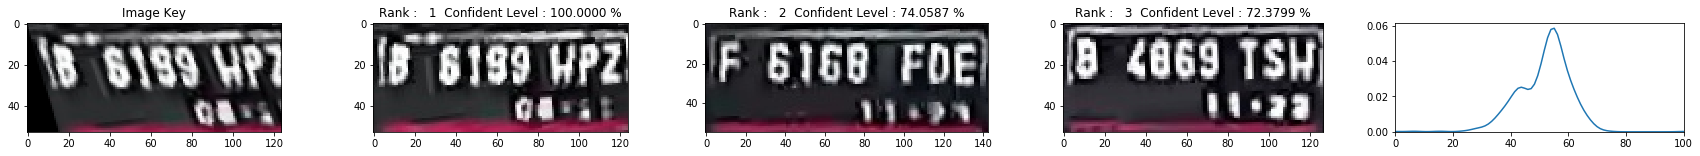

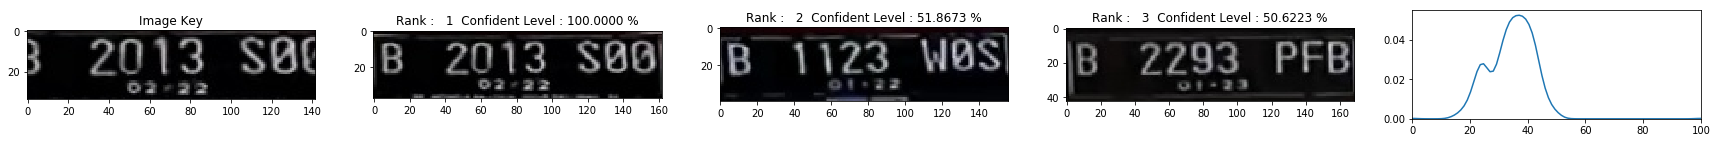

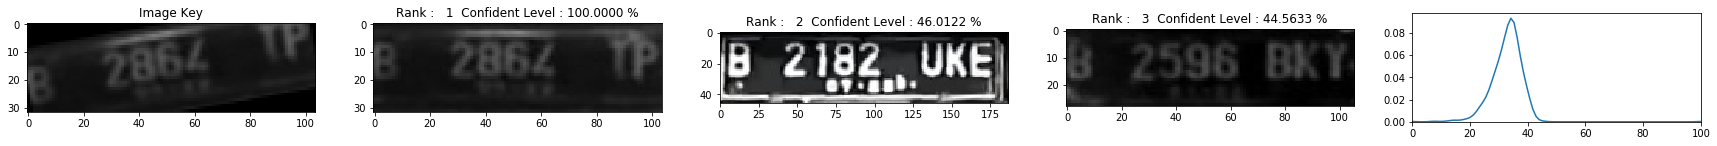

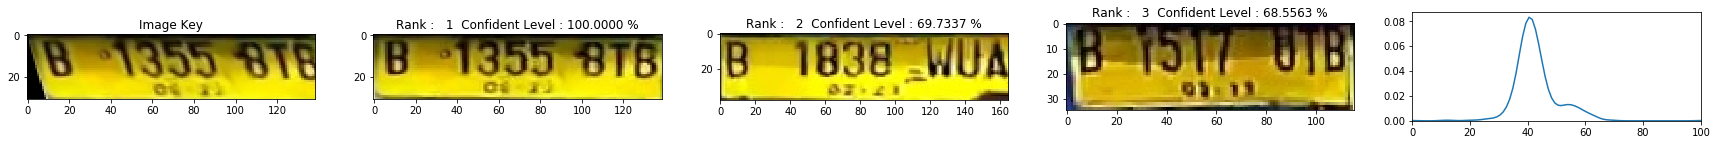

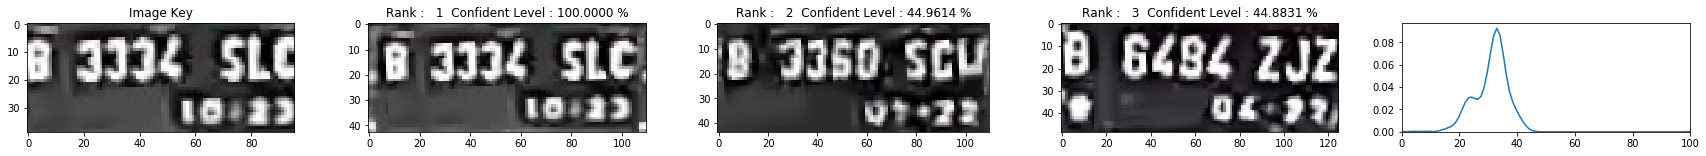

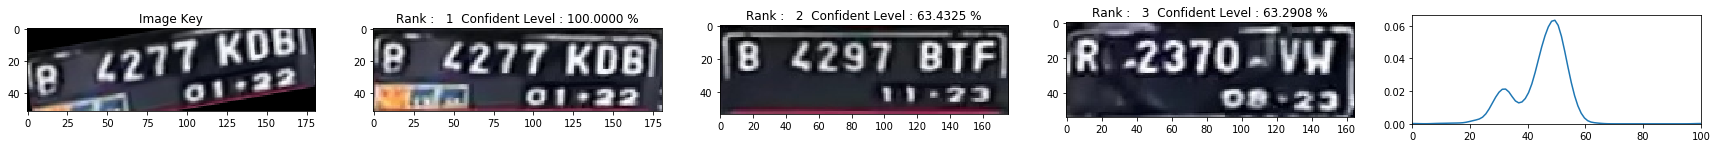

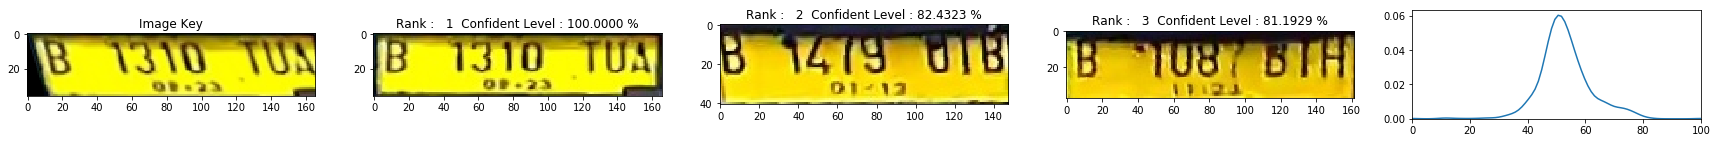

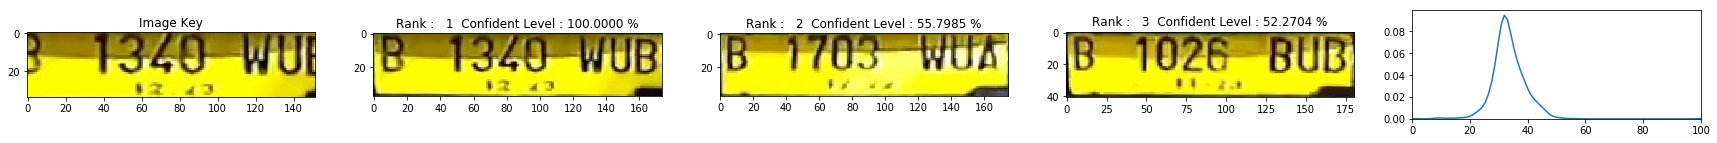

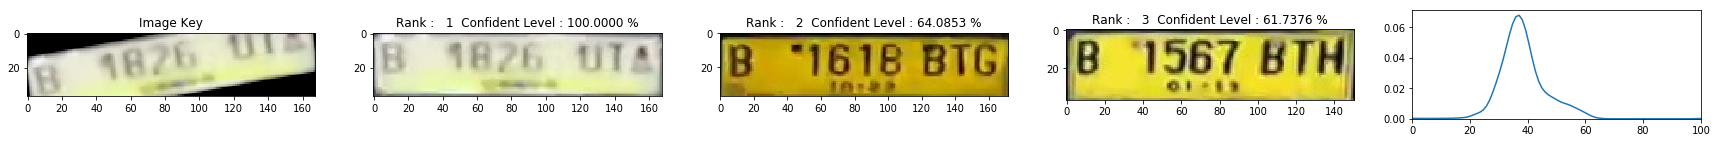

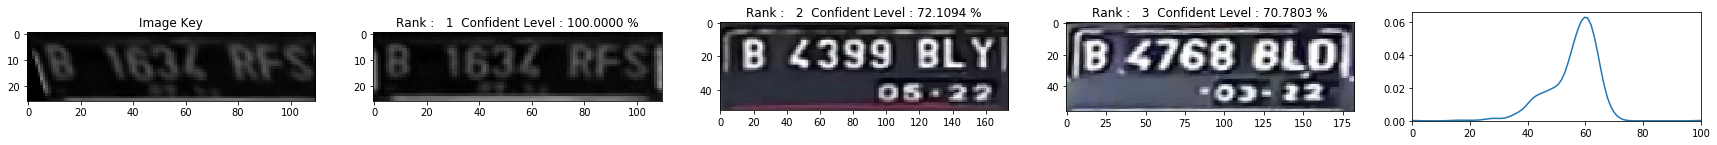

Duration : 0:02:21.446543
Duration similarity per image key : 0:00:14.144654
Duration similarity image per image : 0:00:00.012375


In [8]:
start_time = datetime.now()

for image in image_key_list:
    summary_SIFT(image, data)

end_time = datetime.now()
print('Duration : {}'.format(end_time - start_time))
print('Duration similarity per image key : {}'.format((end_time - start_time)/(NUM_SAMPLE)))
print('Duration similarity image per image : {}'.format((end_time - start_time)/(NUM_SAMPLE*len(data))))

## 2.3. SURF

In [9]:
def match_surf_distanceMAE(match):
    distance = []
    for i in range(len(match)):
        distance.append(match[i].distance)
    MAE = np.mean(np.abs(distance))
    return MAE

def summary_SURF(_img_key, _data):
    surf_dist_list = []
    image_list = []
    for i in range(len(_data)):
        name = _data[i]
        img = cv2.imread(DIR_DATASET + name)
        #img = resize(img, shape = shape_key)
        match = compareSURF(_img_key, img)
        surf_dist = match_surf_distanceMAE(match)
        surf_dist_list.append((i, surf_dist))
        image_list.append(img)
    
# Mengurutkan nilai dari yang terkecil ke terbesar
    surf_dist_list.sort(key=(lambda x : x[1]))
    
    # Normalisasi nilai
    surf_dist_list = np.array(surf_dist_list)
    surf_dist_list[:,1] = 100 - (( surf_dist_list[:,1] - surf_dist_list[:,1].min() )* 100/( surf_dist_list[:,1].max() - surf_dist_list[:,1].min() ))
    #surf_dist_list[:,1] = 100 - (( surf_dist_list[:,1] - 0.0 )* 100/( surf_dist_list[:,1].max() - 0.0 ))
    
    rank = 0
    f = plt.figure(figsize = (30,2))
    ax = f.add_subplot(1, 5, 1)
    ax.imshow(_img_key)
    plt.title('Image Key')
    
    for i, dist in surf_dist_list[:3]:
        rank += 1
        title = 'Rank : {:3d}  Confident Level : {:7.4f} %'.format(rank, dist)
        ax = f.add_subplot(1, 5, rank+1)
        image = cv2.cvtColor(image_list[int(i)], cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        plt.title(title)
    
    ax = f.add_subplot(1, 5, 5)
    #ax.hist(hash_dist_list[:,1], bins = 10)
    sns.kdeplot(surf_dist_list[:,1])
    plt.xlim(0,100)
    plt.show()

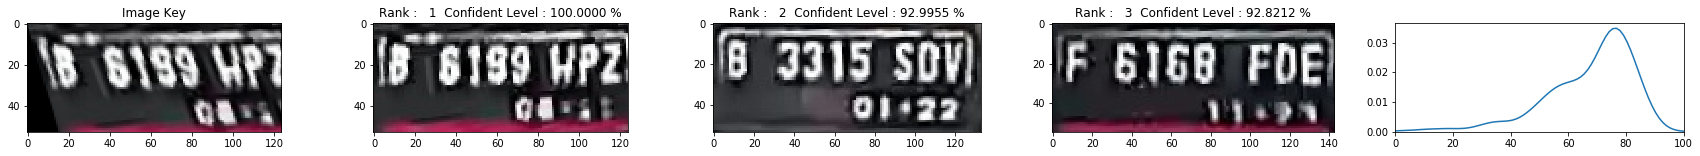

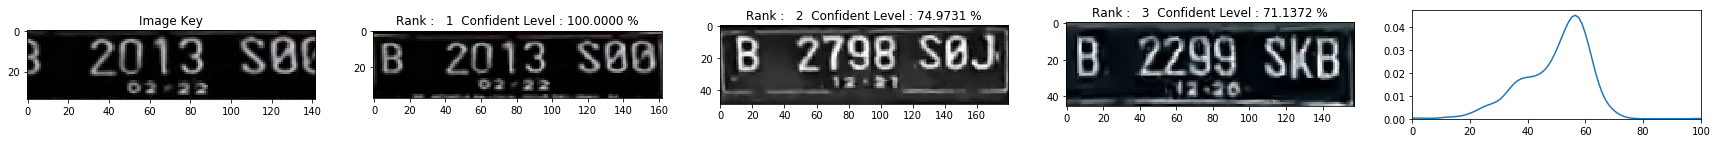

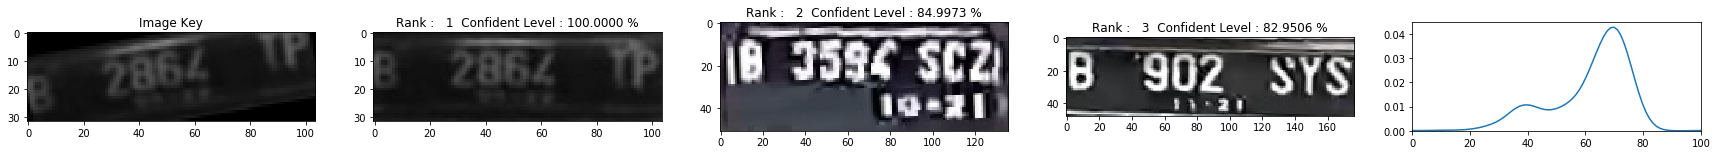

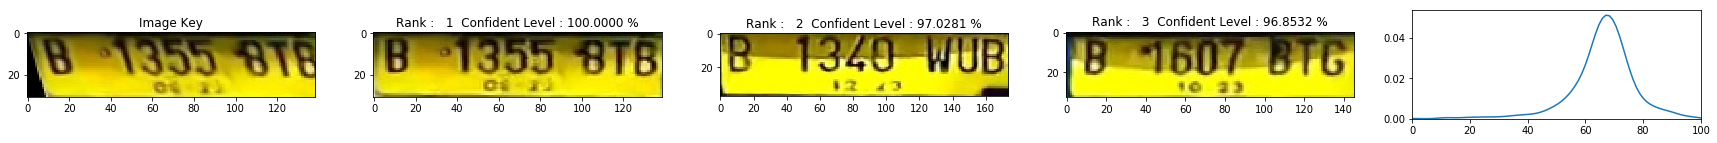

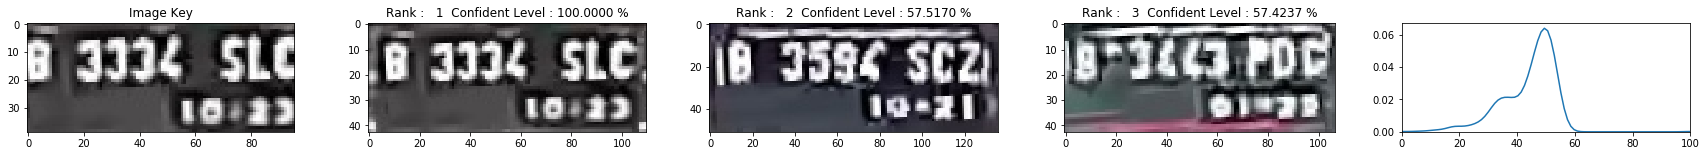

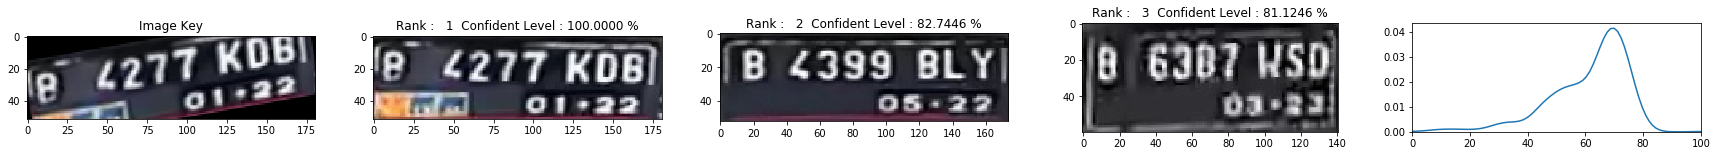

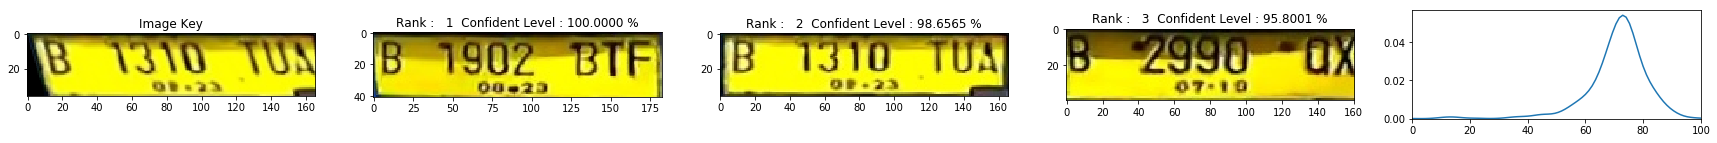

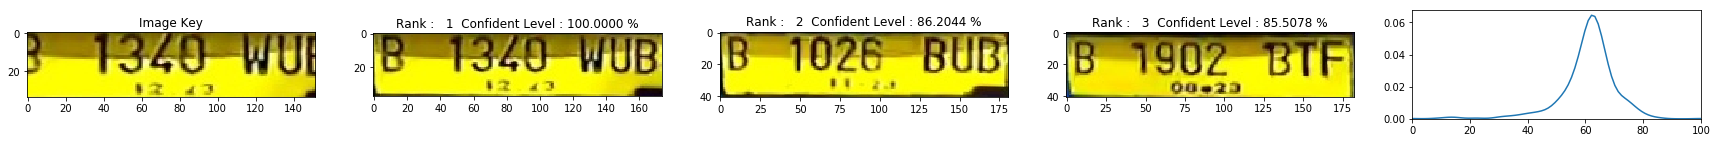

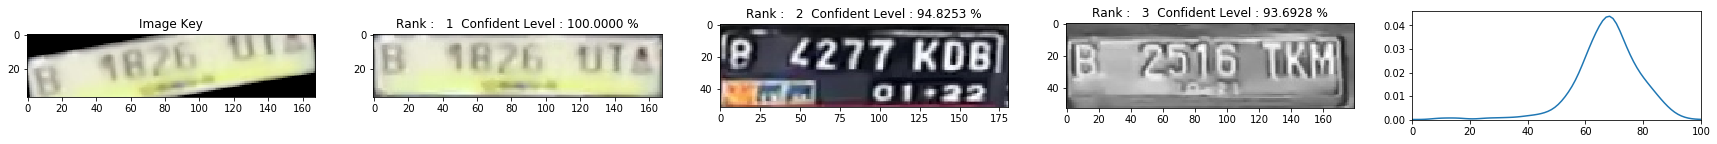

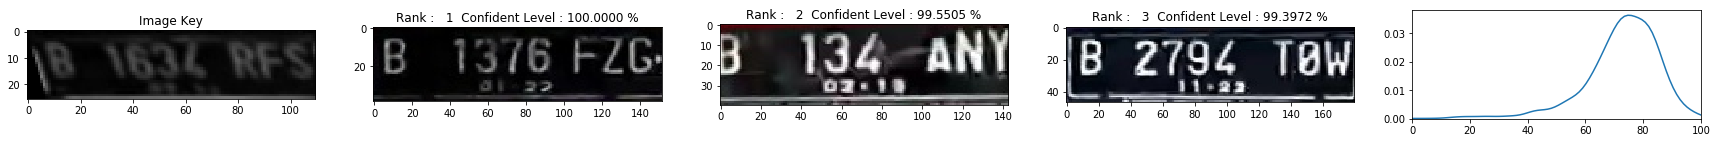

Duration : 0:00:38.738559
Duration similarity per image key : 0:00:03.873856
Duration similarity image per image : 0:00:00.003389


In [10]:
start_time = datetime.now()

for image in image_key_list:
    summary_SURF(image, data)

end_time = datetime.now()
print('Duration : {}'.format(end_time - start_time))
print('Duration similarity per image key : {}'.format((end_time - start_time)/(NUM_SAMPLE)))
print('Duration similarity image per image : {}'.format((end_time - start_time)/(NUM_SAMPLE*len(data))))